In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
#os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q3: Efficient Tracking

Make sure to comment your code and use proper names for your variables.

## Q3.1: Lucas-Kanade with Inverse Composition

In [3]:
from scipy.ndimage import affine_transform
import cv2
import scipy.ndimage
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.morphology import binary_opening, binary_closing
from scipy.ndimage import affine_transform

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    
    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    # M = np.eye(3)
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your Efficient LK implementation here:
    p=[1,0,0,0,1,0]
    dp=np.ones((1,5))
    it1_rbs=RectBivariateSpline(np.arange(It.shape[0]),np.arange(It.shape[1]),It1)
    it_rbs=RectBivariateSpline(np.arange(It.shape[0]),np.arange(It.shape[1]),It)
    coord_x,coord_y= np.meshgrid(np.arange(0,It.shape[1]),np.arange(0,It.shape[0]))
    gintx,ginty = it_rbs.ev(coord_y,coord_x,dx=0,dy=1).flatten(),it_rbs.ev(coord_y,coord_x,dx=1,dy=0).flatten()
    A=np.column_stack([np.multiply(gintx,coord_x.flatten()),np.multiply(gintx, coord_y.flatten()),gintx,np.multiply(ginty, coord_x.flatten()),np.multiply(ginty, coord_y.flatten()),ginty])
    while np.linalg.norm(dp)>=threshold:
        coord_xn = p[0]*coord_x+p[1]*coord_y+p[2]
        coord_yn = p[3]*coord_x+p[4]*coord_y+p[5]
        valid=(coord_xn > 0)&(coord_xn<It1.shape[1])&(coord_yn>0)&(coord_yn<It1.shape[0])
        coord_xn,coord_yn=coord_xn[valid],coord_yn[valid]
        Iint=it1_rbs.ev(coord_yn,coord_xn)
        A1=A[valid.flatten()]
        b=Iint.flatten()-It[valid].flatten()
        b1=np.dot(A1.T, b)
        dp,_,_,_ = np.linalg.lstsq(np.dot(A1.T,A1),b1,rcond=None)
        M=np.vstack((np.reshape(p, (2, 3)),np.array([[0, 0, 1]])))
        dm=np.vstack((np.reshape(dp, (2, 3)), np.array([[0, 0, 1]])))
        dm[0,0]+=1
        dm[1,1]+=1
        M=np.dot(M,np.linalg.inv(dm))
        p=M[:2, :].flatten()

    M=M[:2, :]
    # ----------------------------------------------------------------------------------------------
    return M

## Q3.1 Subtract Dominant Motion

Re-use your implementation for Q2.2. 

Just make sure to use InverseCompositionAffine within. 

In [4]:
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    mask = np.zeros(It1.shape, dtype=bool)

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    M=InverseCompositionAffine(It,It1,threshold,num_iters)
    if M.shape[0] < 3:
        M=np.vstack((M, np.array([[0, 0, 1]])))
    M=np.linalg.inv(M)
    warp_image1=scipy.ndimage.affine_transform(It,M[0:2,0:2],offset = M[0:2,2],output_shape = It1.shape)
    mask[abs(warp_image1-It1)>tolerance]=1
    mask[warp_image1==0]=0

    # ----------------------------------------------------------------------------------------------
    return mask 

## Q3.2: Track Sequence

Re-use your implementation for Q2.3

In [5]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:,:,0]

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        It1 = seq[:,:,i]
        mask = SubtractDominantMotion(It,It1,num_iters, threshold, tolerance)
        masks.append(mask)
        It=It1
    # ----------------------------------------------------------------------------------------------
    masks = np.stack(masks, axis=2)
    return masks

### Q3.2: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [18]:
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1e4
threshold = 1e-2
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(r'C:\Users\balub\OneDrive\Desktop\CV HW2\antseqmasks.npy', masks)

100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:09<00:00, 12.47it/s]


In [19]:
import cProfile
cProfile.run('TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)')

100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:10<00:00, 11.90it/s]

         138059 function calls (135778 primitive calls) in 10.445 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   10.445   10.445 2181175384.py:1(TrackSequenceAffineMotion)
      124    0.731    0.006    9.471    0.076 3560804849.py:8(InverseCompositionAffine)
      124    0.108    0.001   10.376    0.084 523018123.py:4(SubtractDominantMotion)
      496    0.000    0.000    0.004    0.000 <__array_function__ internals>:2(all)
      788    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(atleast_2d)
      124    0.000    0.000    0.006    0.000 <__array_function__ internals>:2(broadcast_arrays)
      124    0.000    0.000    0.157    0.001 <__array_function__ internals>:2(column_stack)
      913    0.001    0.000    0.180    0.000 <__array_function__ internals>:2(concatenate)
      124    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(copyto)
      496    0.00

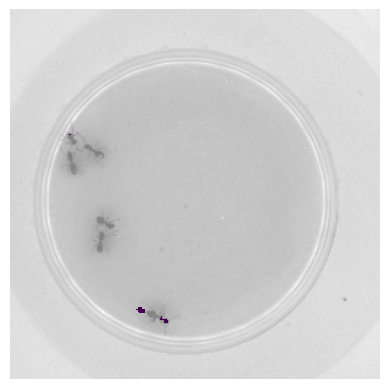

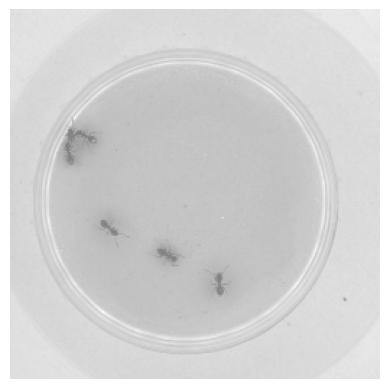

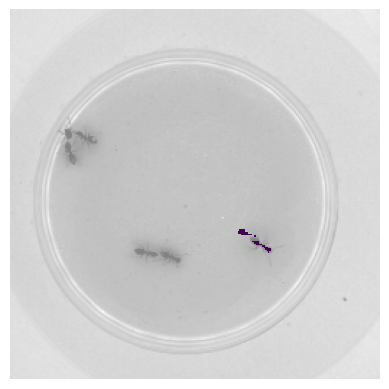

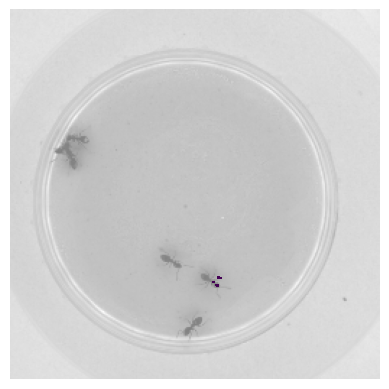

In [20]:
# TODO: visualize. Re-use your implementation for Q2.3
frames_to_save = [30,60,90,120]

for idx in frames_to_save:
    frame = seq[:,:,idx]
    mask = masks[:,:,idx-1]
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"C:/Users/balub/OneDrive/Desktop/CV HW2/antseq_images_inverse/sol_2.3_antseq_{idx+1}.png")

### Q3.2: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [15]:
seq = np.load(r"C:\Users\balub\Downloads\hw2-s23\hw2\data\aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1e4
threshold = 1e-2
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(r'C:\Users\balub\OneDrive\Desktop\CV HW2\aerialseqmasks.npy', masks)

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:25<00:00,  5.95it/s]


In [16]:
import cProfile
cProfile.run('TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)')

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:27<00:00,  5.39it/s]

         326307 function calls (319821 primitive calls) in 27.687 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002   27.686   27.686 2181175384.py:1(TrackSequenceAffineMotion)
      149    2.473    0.017   26.445    0.177 3560804849.py:8(InverseCompositionAffine)
      149    0.137    0.001   27.550    0.185 523018123.py:4(SubtractDominantMotion)
      596    0.000    0.000    0.005    0.000 <__array_function__ internals>:2(all)
     2445    0.001    0.000    0.007    0.000 <__array_function__ internals>:2(atleast_2d)
      149    0.000    0.000    0.006    0.000 <__array_function__ internals>:2(broadcast_arrays)
      149    0.000    0.000    0.191    0.001 <__array_function__ internals>:2(column_stack)
     2595    0.002    0.000    0.231    0.000 <__array_function__ internals>:2(concatenate)
      149    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(copyto)
      596    0.00

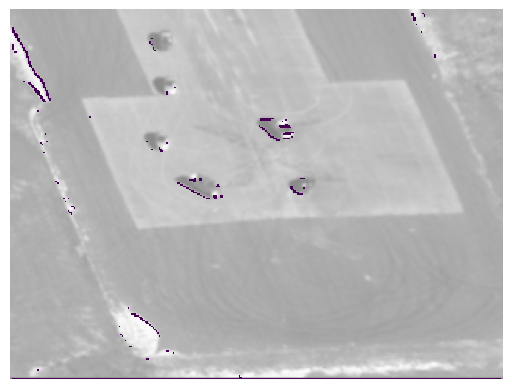

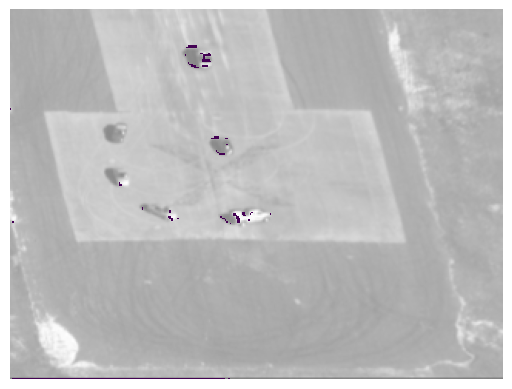

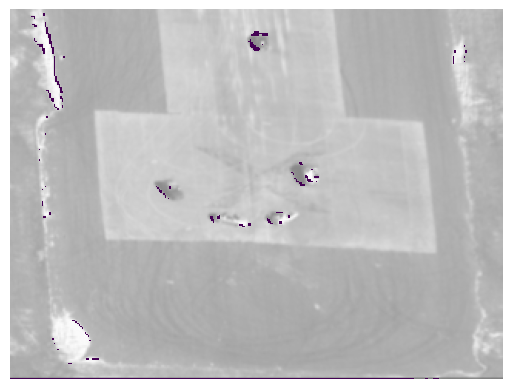

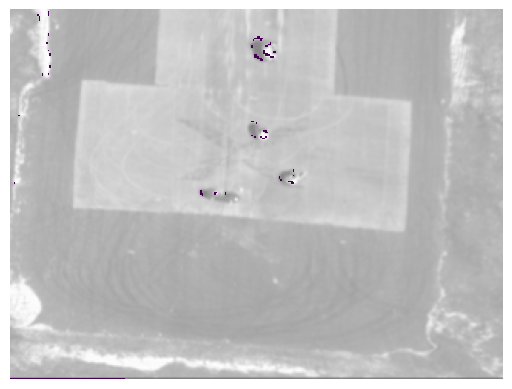

In [17]:
# TODO: visualize. Re-use your implementation for Q2.3
frames_to_save = [30,60,90,120]

for idx in frames_to_save:
    frame = seq[:,:,idx-1]
    mask = masks[:,:,idx-1]
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"C:/Users/balub/OneDrive/Desktop/CV HW2/aerialseq_images_inverse/sol_2.3_antseq_{idx+1}.png")